# Análise Computacional de Jogos Estocásticos Cooperativos e Não Cooperativos

### Introdução e Contexto
Modelamos a interação estratégica entre transmissores em um sistema de comunicação sem fio sujeito a interferência como um **Jogo Estocástico**. O estado global $s$ combina tamanhos de filas e estados de canal; as ações de transmissão $\mathbf{a}$ definem a evolução do sistema.

Analisamos três regimes:
1. **Soma Zero (Zero-Sum):** ganho de um é perda do outro ($U_1 = -U_2$).
2. **Não-Cooperativo (Non-Cooperative):** cada jogador maximiza sua própria utilidade (Equilíbrio de Nash).
3. **Cooperativo (Team Optimal):** jogadores coordenam ações para maximizar o throughput global.

### Formulação Matemática (Programação Linear)
Resolvido via **Programação Linear** sobre a **medida de ocupação** $\rho(s,a)$ (probabilidade conjunta de estado/ação), em vez de otimizar diretamente $\pi(a|s)$.

**Problema de Otimização (jogador $i$):**
$$\max_{\rho} \sum_{s \in S} \sum_{a \in A} C_i(s,a) \cdot \rho(s,a)$$

**Restrições:**
1. **Conservação de Fluxo:**
   $$\sum_{a' \in A} \rho(y,a') = \sum_{s \in S} \sum_{a \in A} P(y|s,a) \cdot \rho(s,a), \quad \forall y \in S$$
2. **Normalização:**
   $$\sum_{s \in S} \sum_{a \in A} \rho(s,a) = 1$$
3. **Não-negatividade:** $\rho(s,a) \ge 0$.

Onde $S$ (estados: canais x filas), $A$ (ações: potência x admissão), $C_i(s,a)$ (recompensa via SINR), $P(y|s,a)$ (transições).

## Parte 1
### Implementação do Código e Solver
- **`queuedefs`:** constrói matrizes de transição $P$ e custos $C$ (fila + SINR).
- **`queuestr_lp`:** solver LP (via `scipy.linprog`), agora com parâmetro opcional `Bmax` para restrição de backlog médio.
- **`queuesolvegame_py`:** algoritmo iterativo de **Melhor Resposta** alternando jogadores até convergir.
Demais utilitários: heurística de chute inicial, extração/plot de políticas e cálculo de throughput/backlog médio. Em seguida rodamos Zero-Sum, Não-Coop e Coop, e reconstruímos os agregados para os gráficos finais.


In [1]:

import numpy as np
from dataclasses import dataclass
from scipy.optimize import linprog

ZEROSUM        = 1
DECENTRCOOP    = 2
DECENTRNONCOOP = 3

@dataclass
class Settings:
    NLinkStates: int
    NBufferStates: int
    NPowActs: int
    NAdmContrActs: int
    ArrProb: float
    v1: float
    v2: float
    rho1: any = np.nan
    rho2: any = np.nan
    CostFunction: int = DECENTRNONCOOP


def queuedefs(s: Settings):
    NS, NB, NA, NB_adm = s.NLinkStates, s.NBufferStates, s.NPowActs, s.NAdmContrActs
    arr_prob, v1, v2, cost_mode = s.ArrProb, s.v1, s.v2, s.CostFunction

    # Channel transition (reflecting random walk)
    PL = np.zeros((NS, NS))
    for j in range(NS):
        if j == 0:
            PL[j, j] = 0.5; PL[j, j+1] = 0.5
        elif j == NS-1:
            PL[j, j] = 0.5; PL[j, j-1] = 0.5
        else:
            PL[j, j-1:j+2] = [1/3, 1/3, 1/3]

    # Steady-state distribution
    P1 = PL.T - np.eye(NS)
    P1 = np.vstack([P1[:-1, :], np.ones((1, NS))])
    e1 = np.zeros(NS); e1[-1] = 1
    pi = np.linalg.solve(P1, e1)

    def queuepos1(i, j, a, b):
        return (((i) * NB + j) * NA + a) * NB_adm + b

    # Queue transitions: P[j,a,b,new_j]
    P = np.zeros((NB, NA, NB_adm, NB))
    for j in range(NB):
        for a in range(NA):
            for b in range(NB_adm):
                served = min(j, 1) if a != 0 else 0
                new_sz_arr = min(j - served + b, NB - 1)
                new_sz_no = j - served
                P[j, a, b, new_sz_arr] += arr_prob
                P[j, a, b, new_sz_no] += (1 - arr_prob)

    # Channel qualities
    Nu = np.linspace(0.0, 1.0, NS)
    N0, s_coeff = 1.0, 1.0

    # Cost matrices
    c1 = np.zeros((NS, NA, NS, NA))
    c2 = np.zeros_like(c1)
    for x in range(NS):
        for a in range(1, NA + 1):
            for y in range(NS):
                for b in range(1, NA + 1):
                    SINR1 = ((a - 1) * Nu[x]) / (N0 + s_coeff * (b - 1) * Nu[y])
                    SINR2 = ((b - 1) * Nu[y]) / (N0 + s_coeff * (a - 1) * Nu[x])
                    SINR1, SINR2 = max(SINR1, 0.0), max(SINR2, 0.0)
                    if cost_mode == ZEROSUM:
                        c1[x, a - 1, y, b - 1] = np.log2(1.0 + SINR1)
                        c2[x, a - 1, y, b - 1] = -c1[x, a - 1, y, b - 1]
                    elif cost_mode == DECENTRCOOP:
                        tot = np.log2(1.0 + SINR1) + np.log2(1.0 + SINR2)
                        c1[x, a - 1, y, b - 1] = tot
                        c2[x, a - 1, y, b - 1] = tot
                    else:  # DECENTRNONCOOP
                        c1[x, a - 1, y, b - 1] = np.log2(1.0 + SINR1)
                        c2[x, a - 1, y, b - 1] = np.log2(1.0 + SINR2)

    d1 = np.arange(NA, dtype=float).reshape(1, -1)
    d2 = d1.copy()

    return dict(NS=NS, NB=NB, NA=NA, NB_adm=NB_adm,
                PL=PL, P=P, Nu=Nu, N0=N0, s_coeff=s_coeff,
                c1=c1, c2=c2, d1=d1, d2=d2, steadystate_pi=pi,
                NStates=NS * NB * NA * NB_adm, queuepos1=queuepos1,
                v1=v1, v2=v2, CostFunction=cost_mode)



def queuestr_lp(for_player: int, rho_other: np.ndarray, defs: dict, Bmax=None):
    """
    Best-response LP for one player against opponent's occupation measure.

      - if both queues non-empty:   use payoff(i,a,k,d)
      - if j==0, l>0:               freeze player-1 power -> a := 0
      - if j>0, l==0:               freeze player-2 power -> d := 0
      - if j==0, l==0:              contributes nothing

    In DECENTRCOOP, maximize sum-rate (c1+c2). In DECENTRNONCOOP/ZEROSUM, each
    player uses its own payoff tensor (c1 for player 1, c2 for player 2).
    Optional Bmax adds an average-backlog inequality: sum(j * rho) <= Bmax.
    """
    NS, NB, NA, NB_adm = defs['NS'], defs['NB'], defs['NA'], defs['NB_adm']
    c1, c2, d1, d2 = defs['c1'], defs['c2'], defs['d1'], defs['d2']
    v1, v2 = defs['v1'], defs['v2']
    PL, Pq = defs['PL'], defs['P']
    queuepos1 = defs['queuepos1']
    cost_mode = defs.get('CostFunction', DECENTRNONCOOP)

    NVars = NS * NB * NA * NB_adm
    f = np.zeros(NVars, dtype=float)

    # ----- Objective: case logic without "served" multiplier -----
    for i in range(NS):
        for j in range(NB):
            for a in range(NA):
                for b in range(NB_adm):
                    acc = 0.0
                    for k in range(NS):
                        for l in range(NB):
                            mass2_over_d = np.sum(rho_other[k, l, :, :], axis=-1)  # shape [NA]
                            if mass2_over_d.size == 0 or np.allclose(mass2_over_d.sum(), 0.0):
                                continue

                            if cost_mode == DECENTRCOOP:
                                for d in range(NA):
                                    if (l > 0) and (j > 0):
                                        acc += c1[i, a, k, d] * mass2_over_d[d]
                                    elif (l > 0) and (j == 0):
                                        acc += c1[i, 0, k, d] * mass2_over_d[d]
                                    elif (j > 0) and (l == 0):
                                        acc += c1[i, a, k, 0] * mass2_over_d[d]
                            else:
                                for d in range(NA):
                                    if for_player == 1:
                                        if (l > 0) and (j > 0):
                                            acc += c1[i, a, k, d] * mass2_over_d[d]
                                        elif (l > 0) and (j == 0):
                                            acc += c1[i, 0, k, d] * mass2_over_d[d]
                                        elif (j > 0) and (l == 0):
                                            acc += c1[i, a, k, 0] * mass2_over_d[d]
                                    else:
                                        if (l > 0) and (j > 0):
                                            acc += c2[k, d, i, a] * mass2_over_d[d]
                                        elif (l > 0) and (j == 0):
                                            acc += c2[k, d, i, 0] * mass2_over_d[d]
                                        elif (j > 0) and (l == 0):
                                            acc += c2[k, 0, i, a] * mass2_over_d[d]

                    f[queuepos1(i, j, a, b)] = acc

    fmax = np.max(np.abs(f))
    if fmax > 0:
        f /= fmax
    else:
        raise RuntimeError("Objective vector is all zeros; check payoffs and masks.")

    bounds = []
    for i in range(NS):
        for j in range(NB):
            for a in range(NA):
                for b in range(NB_adm):
                    ub = 1.0
                    if j == 0 and (b == 0 or a > 0):
                        ub = 0.0
                    bounds.append((0.0, ub))

    n_states = NS * NB
    Aeq_flow = np.zeros((n_states, NVars))
    beq_flow = np.zeros(n_states)

    def sidx(ii, jj):
        return ii * NB + jj

    for i in range(NS):
        for j in range(NB):
            row = sidx(i, j)
            for a in range(NA):
                for b in range(NB_adm):
                    Aeq_flow[row, queuepos1(i, j, a, b)] += 1.0

    for ip in range(NS):
        for jp in range(NB):
            for ap in range(NA):
                for bp in range(NB_adm):
                    colp = queuepos1(ip, jp, ap, bp)
                    for i in range(NS):
                        pij_link = PL[ip, i]
                        if pij_link == 0.0:
                            continue
                        for j in range(NB):
                            pij_queue = Pq[jp, ap, bp, j]
                            if pij_queue == 0.0:
                                continue
                            row = sidx(i, j)
                            Aeq_flow[row, colp] -= pij_link * pij_queue

    Aeq = np.vstack([Aeq_flow, np.ones((1, NVars))])
    beq = np.concatenate([beq_flow, [1.0]])

    vlim, dvec = (v1, d1[0]) if for_player == 1 else (v2, d2[0])
    A_ub = np.zeros((1, NVars))
    idx = 0
    for i in range(NS):
        for j in range(NB):
            for a in range(NA):
                for b in range(NB_adm):
                    A_ub[0, idx] = dvec[a]
                    idx += 1
    b_ub = np.array([vlim])

    if Bmax is not None:
        A_backlog = np.zeros((1, NVars))
        idx = 0
        for i in range(NS):
            for j in range(NB):
                for a in range(NA):
                    for b in range(NB_adm):
                        A_backlog[0, idx] = j
                        idx += 1
        A_ub = np.vstack([A_ub, A_backlog])
        b_ub = np.concatenate([b_ub, np.array([float(Bmax)])])

    res = linprog(c=-f, A_ub=A_ub, b_ub=b_ub, A_eq=Aeq, b_eq=beq,
                  bounds=bounds, method="highs")
    if not res.success:
        raise RuntimeError(f"LP failed for player {for_player}: {res.message}")

    x = res.x
    val = -res.fun
    rho = x.reshape(NS, NB, NA, NB_adm)
    constr_val = np.sum(rho * dvec.reshape(1, 1, -1, 1))
    print(f"[Player {for_player}] val={val:.6f}, power={constr_val:.6f} (limit={vlim:.6f})")
    return rho, val, constr_val


# === Iterative Solver for Decentralized Equilibrium — `queuesolvegame_py`

def queuesolvegame_py(s: Settings, init_policy_guess=True, Bmax=None):
    defs = queuedefs(s)
    NS, NB, NA, NB_adm = defs['NS'], defs['NB'], defs['NA'], defs['NB_adm']

    if init_policy_guess:
        rho1 = make_initial_guess_policy(NS, NB, NA, NB_adm)
        rho2 = make_initial_guess_policy(NS, NB, NA, NB_adm)
        print("[Init] Using policy-based equilibrium guess.")
    else:
        rho1 = np.ones((NS, NB, NA, NB_adm)) / (NS * NB * NA * NB_adm)
        rho2 = np.copy(rho1)
        print("[Init] Using uniform equilibrium guess.")

    max_it, eps = 30, 1e-10
    val1_prev = val2_prev = 0.0

    for it in range(1, max_it + 1):
        rho1, val1, _ = queuestr_lp(1, rho2, defs, Bmax=Bmax)
        rho2, val2, _ = queuestr_lp(2, rho1, defs, Bmax=Bmax)
        print(f"[Iter {it}] val1={val1:.6f}, val2={val2:.6f}, Δ1={abs(val1 - val1_prev):.3e}, Δ2={abs(val2 - val2_prev):.3e}")
        if abs(val1 - val1_prev) < eps and abs(val2 - val2_prev) < eps:
            break
        val1_prev, val2_prev = val1, val2

    return val1, val2, rho1, rho2


def make_initial_guess_policy(NS, NB, NA, NB_adm):
    """
    Create a prior (initial guess) for ρ[i,j,a,b] based on heuristic equilibrium rules.
    - i: link state ∈ {0,...,NS-1}
    - j: buffer state ∈ {0,...,NB-1}
    - a: power action ∈ {0,...,NA-1}
    - b: admission action ∈ {0,1} (0=reject, 1=accept)
    """
    rho = np.zeros((NS, NB, NA, NB_adm))

    for i in range(NS):
        for j in range(NB):
            for b in range(NB_adm):
                for a in range(NA):
                    if j == 0:
                        rho[i, j, a, b] = 1.0
                    elif j in [1, 2]:
                        if i == 3 and a > 0 and b == 1:
                            rho[i, j, a, b] = 1.0
                        else:
                            rho[i, j, a, b] = 0.1
                    elif j in [3, 4, 5, 6]:
                        if i in [2, 3] and a > 0 and b == 1:
                            rho[i, j, a, b] = 1.0
                        else:
                            rho[i, j, a, b] = 0.1
                    elif j == 7:
                        if i in [2, 3] and a == NA - 1 and b == 1:
                            rho[i, j, a, b] = 1.0
                        else:
                            rho[i, j, a, b] = 0.05

    rho /= np.sum(rho)
    return rho


# === Basic setup: shared definitions and helper functions ===
import numpy as np
import matplotlib.pyplot as plt

v1l = 2.0
common_kwargs = dict(NLinkStates=4, NBufferStates=8, NPowActs=6, NAdmContrActs=2, ArrProb=0.5, v1=v1l, v2=v1l)

def describe_model(s):
    print("=== Model Configuration ===")
    print(f"Number of channel (link) states: {s.NLinkStates}")
    print(f"Number of buffer states:         {s.NBufferStates}")
    print(f"Number of power control actions: {s.NPowActs}")
    print(f"Number of admission actions:     {s.NAdmContrActs}")
    print(f"Arrival probability:             {s.ArrProb}")
    print(f"v1 (Player 1 power limit):       {s.v1}")
    print(f"v2 (Player 2 power limit):       {s.v2}")
    print("========================================")

def extract_policy(rho, NS, NB, NA, NAdm):
    policy = np.zeros((NS, NB), dtype=int)
    for i in range(NS):
        for j in range(NB):
            power_dist = np.sum(rho[i, j, :, :], axis=1)
            policy[i, j] = np.argmax(power_dist)
    return policy

def extract_admission_policy(rho, NS, NB, NA, NAdm):
    policy = np.zeros((NS, NB), dtype=int)
    for i in range(NS):
        for j in range(NB):
            adm_dist = np.sum(rho[i, j, :, :], axis=0)
            policy[i, j] = np.argmax(adm_dist)
    return policy

def plot_policies(s, policy1, policy2, adm_policy1, adm_policy2, title_prefix=""):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    im1 = ax[0].imshow(policy1, origin='lower', cmap='viridis')
    im2 = ax[1].imshow(policy2, origin='lower', cmap='viridis')
    ax[0].set_title(f"{title_prefix} Power – Player 1")
    ax[1].set_title(f"{title_prefix} Power – Player 2")
    for a in ax:
        a.set_xlabel("Buffer state"); a.set_ylabel("Link state")
        a.set_xticks(range(s.NBufferStates)); a.set_yticks(range(s.NLinkStates))
    fig.colorbar(im1, ax=ax[0]); fig.colorbar(im2, ax=ax[1])
    plt.tight_layout(); plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    im1 = ax[0].imshow(adm_policy1, origin='lower', cmap='coolwarm')
    im2 = ax[1].imshow(adm_policy2, origin='lower', cmap='coolwarm')
    ax[0].set_title(f"{title_prefix} Admission – Player 1")
    ax[1].set_title(f"{title_prefix} Admission – Player 2")
    for a in ax:
        a.set_xlabel("Buffer state"); a.set_ylabel("Link state")
        a.set_xticks(range(s.NBufferStates)); a.set_yticks(range(s.NLinkStates))
    fig.colorbar(im1, ax=ax[0]); fig.colorbar(im2, ax=ax[1])
    plt.tight_layout(); plt.show()


# === Utility: Evaluate true physical throughput (rate expectation) ===

def evaluate_physical_throughput(rho1, rho2, defs):
    NS, NB, NA, NB_adm = defs['NS'], defs['NB'], defs['NA'], defs['NB_adm']
    Nu, N0, s_coeff = defs['Nu'], defs['N0'], defs['s_coeff']

    rho1 = rho1 / rho1.sum()
    rho2 = rho2 / rho2.sum()

    r1 = 0.0
    r2 = 0.0

    def rates(i, a, k, d):
        num1 = a * Nu[i]
        num2 = d * Nu[k]
        den1 = N0 + s_coeff * d * Nu[k]
        den2 = N0 + s_coeff * a * Nu[i]
        R1 = 0.0 if den1 <= 0 else np.log2(1.0 + num1 / den1)
        R2 = 0.0 if den2 <= 0 else np.log2(1.0 + num2 / den2)
        return R1, R2

    for i in range(NS):
        for j in range(NB):
            for a in range(NA):
                mass1 = rho1[i, j, a, :].sum()
                if mass1 == 0:
                    continue
                for k in range(NS):
                    for l in range(NB):
                        mass2_p = rho2[k, l, :, :].sum(axis=1)
                        if mass2_p.sum() == 0:
                            continue

                        if (j > 0) and (l > 0):
                            for d in range(NA):
                                R1, R2 = rates(i, a, k, d)
                                r1 += R1 * mass1 * mass2_p[d]
                                r2 += R2 * mass1 * mass2_p[d]
                        elif (j == 0) and (l > 0):
                            for d in range(NA):
                                _, R2 = rates(i, 0, k, d)
                                r2 += R2 * mass1 * mass2_p[d]
                        elif (j > 0) and (l == 0):
                            R1, _ = rates(i, a, k, 0)
                            r1 += R1 * mass1 * mass2_p.sum()

    return r1 + r2, r1, r2


def compute_average_backlog(rho):
    rho = rho / rho.sum()
    NB = rho.shape[1]
    weights = np.arange(NB).reshape(1, NB, 1, 1)
    return float(np.sum(weights * rho))


=== Model Configuration ===
Number of channel (link) states: 4
Number of buffer states:         8
Number of power control actions: 6
Number of admission actions:     2
Arrival probability:             0.5
v1 (Player 1 power limit):       2.0
v2 (Player 2 power limit):       2.0
[Init] Using policy-based equilibrium guess.
[Player 1] val=0.360497, power=2.000000 (limit=2.000000)
[Player 2] val=-0.727816, power=2.000000 (limit=2.000000)
[Iter 1] val1=0.360497, val2=-0.727816, Δ1=3.605e-01, Δ2=7.278e-01
[Player 1] val=0.360528, power=2.000000 (limit=2.000000)
[Player 2] val=-0.727816, power=2.000000 (limit=2.000000)
[Iter 2] val1=0.360528, val2=-0.727816, Δ1=3.068e-05, Δ2=0.000e+00
[Player 1] val=0.360528, power=2.000000 (limit=2.000000)
[Player 2] val=-0.727816, power=2.000000 (limit=2.000000)
[Iter 3] val1=0.360528, val2=-0.727816, Δ1=0.000e+00, Δ2=0.000e+00
[Zero-Sum] val1=0.360528, val2=-0.727816


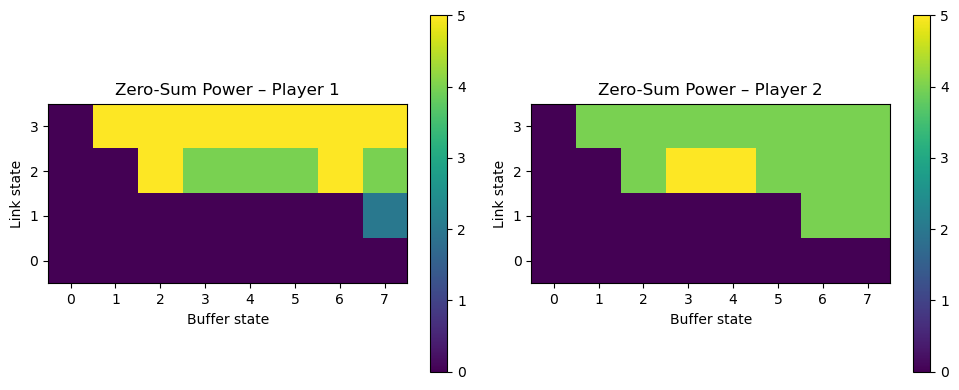

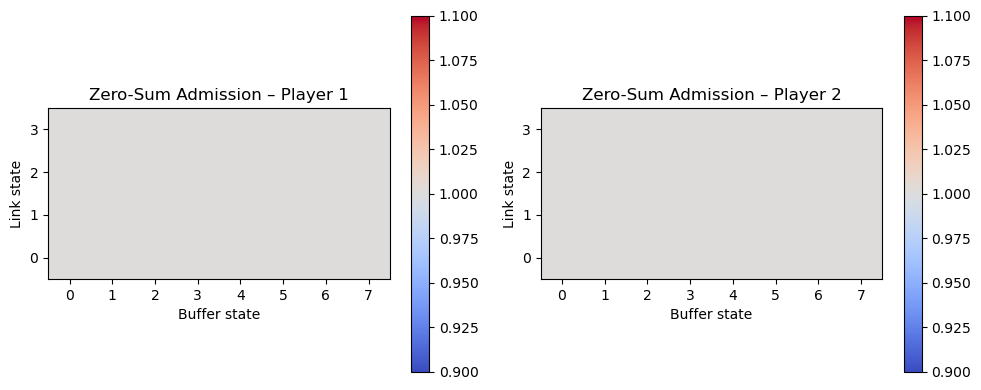

In [2]:
# === Zero-Sum configuration ===
s_zero = Settings(**common_kwargs, CostFunction=ZEROSUM)
describe_model(s_zero)

val1_z, val2_z, rho1_z, rho2_z = queuesolvegame_py(s_zero, init_policy_guess=True)
print(f"[Zero-Sum] val1={val1_z:.6f}, val2={val2_z:.6f}")

policy1_z = extract_policy(rho1_z, s_zero.NLinkStates, s_zero.NBufferStates, s_zero.NPowActs, s_zero.NAdmContrActs)
policy2_z = extract_policy(rho2_z, s_zero.NLinkStates, s_zero.NBufferStates, s_zero.NPowActs, s_zero.NAdmContrActs)
adm1_z = extract_admission_policy(rho1_z, s_zero.NLinkStates, s_zero.NBufferStates, s_zero.NPowActs, s_zero.NAdmContrActs)
adm2_z = extract_admission_policy(rho2_z, s_zero.NLinkStates, s_zero.NBufferStates, s_zero.NPowActs, s_zero.NAdmContrActs)

plot_policies(s_zero, policy1_z, policy2_z, adm1_z, adm2_z, title_prefix="Zero-Sum")


=== Model Configuration ===
Number of channel (link) states: 4
Number of buffer states:         8
Number of power control actions: 6
Number of admission actions:     2
Arrival probability:             0.5
v1 (Player 1 power limit):       2.0
v2 (Player 2 power limit):       2.0
[Init] Using policy-based equilibrium guess.
[Player 1] val=0.360497, power=2.000000 (limit=2.000000)
[Player 2] val=0.361107, power=2.000000 (limit=2.000000)
[Iter 1] val1=0.360497, val2=0.361107, Δ1=3.605e-01, Δ2=3.611e-01
[Player 1] val=0.361107, power=2.000000 (limit=2.000000)
[Player 2] val=0.361107, power=2.000000 (limit=2.000000)
[Iter 2] val1=0.361107, val2=0.361107, Δ1=6.105e-04, Δ2=0.000e+00
[Player 1] val=0.361107, power=2.000000 (limit=2.000000)
[Player 2] val=0.361107, power=2.000000 (limit=2.000000)
[Iter 3] val1=0.361107, val2=0.361107, Δ1=0.000e+00, Δ2=0.000e+00
[Non-Coop] val1=0.361107, val2=0.361107


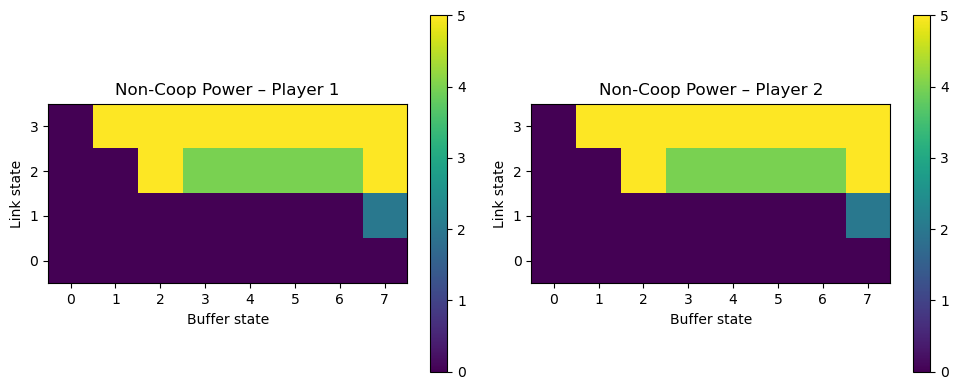

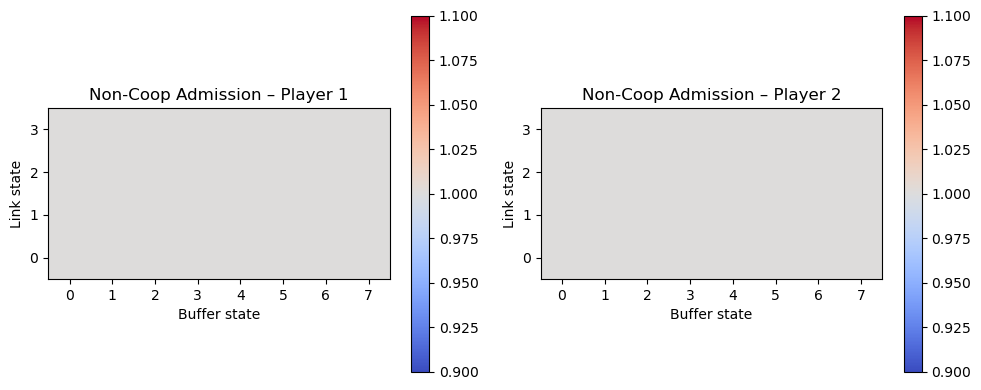

In [3]:
# === Non-Cooperative configuration ===
s_noncoop = Settings(**common_kwargs, CostFunction=DECENTRNONCOOP)
describe_model(s_noncoop)

val1_n, val2_n, rho1_n, rho2_n = queuesolvegame_py(s_noncoop, init_policy_guess=True)
print(f"[Non-Coop] val1={val1_n:.6f}, val2={val2_n:.6f}")

policy1_n = extract_policy(rho1_n, s_noncoop.NLinkStates, s_noncoop.NBufferStates, s_noncoop.NPowActs, s_noncoop.NAdmContrActs)
policy2_n = extract_policy(rho2_n, s_noncoop.NLinkStates, s_noncoop.NBufferStates, s_noncoop.NPowActs, s_noncoop.NAdmContrActs)
adm1_n = extract_admission_policy(rho1_n, s_noncoop.NLinkStates, s_noncoop.NBufferStates, s_noncoop.NPowActs, s_noncoop.NAdmContrActs)
adm2_n = extract_admission_policy(rho2_n, s_noncoop.NLinkStates, s_noncoop.NBufferStates, s_noncoop.NPowActs, s_noncoop.NAdmContrActs)

plot_policies(s_noncoop, policy1_n, policy2_n, adm1_n, adm2_n, title_prefix="Non-Coop")


=== Model Configuration ===
Number of channel (link) states: 4
Number of buffer states:         8
Number of power control actions: 6
Number of admission actions:     2
Arrival probability:             0.5
v1 (Player 1 power limit):       2.0
v2 (Player 2 power limit):       2.0
[Init] Using policy-based equilibrium guess.
[Player 1] val=0.609339, power=2.000000 (limit=2.000000)
[Player 2] val=0.621344, power=2.000000 (limit=2.000000)
[Iter 1] val1=0.609339, val2=0.621344, Δ1=6.093e-01, Δ2=6.213e-01
[Player 1] val=0.621344, power=2.000000 (limit=2.000000)
[Player 2] val=0.621344, power=2.000000 (limit=2.000000)
[Iter 2] val1=0.621344, val2=0.621344, Δ1=1.201e-02, Δ2=0.000e+00
[Player 1] val=0.621344, power=2.000000 (limit=2.000000)
[Player 2] val=0.621344, power=2.000000 (limit=2.000000)
[Iter 3] val1=0.621344, val2=0.621344, Δ1=0.000e+00, Δ2=0.000e+00
[Cooperative] val1=0.621344, val2=0.621344


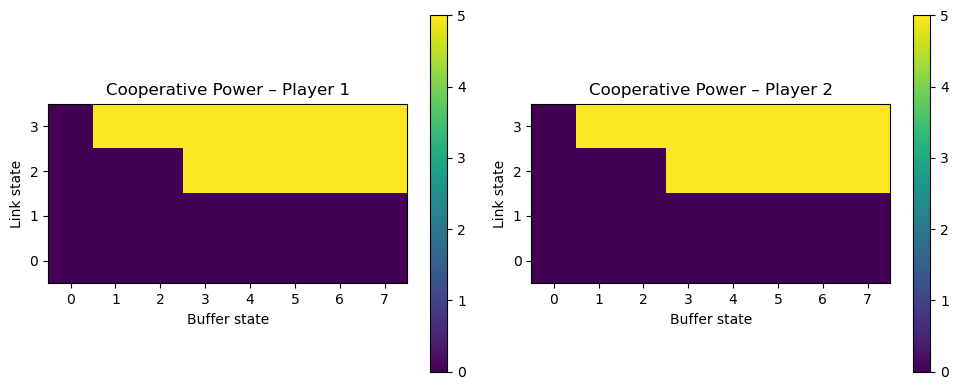

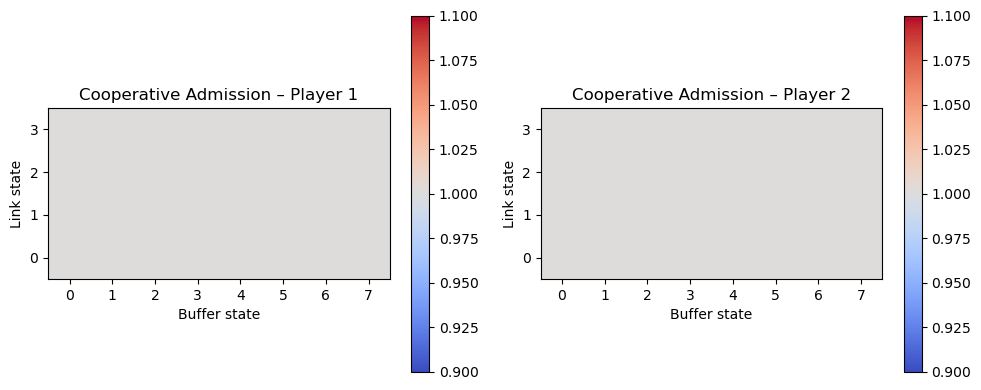

In [4]:
# === Team / Cooperative configuration ===
s_team = Settings(**common_kwargs, CostFunction=DECENTRCOOP)
describe_model(s_team)

val1_c, val2_c, rho1_c, rho2_c = queuesolvegame_py(s_team, init_policy_guess=True)
print(f"[Cooperative] val1={val1_c:.6f}, val2={val2_c:.6f}")

policy1_c = extract_policy(rho1_c, s_team.NLinkStates, s_team.NBufferStates, s_team.NPowActs, s_team.NAdmContrActs)
policy2_c = extract_policy(rho2_c, s_team.NLinkStates, s_team.NBufferStates, s_team.NPowActs, s_team.NAdmContrActs)
adm1_c = extract_admission_policy(rho1_c, s_team.NLinkStates, s_team.NBufferStates, s_team.NPowActs, s_team.NAdmContrActs)
adm2_c = extract_admission_policy(rho2_c, s_team.NLinkStates, s_team.NBufferStates, s_team.NPowActs, s_team.NAdmContrActs)

plot_policies(s_team, policy1_c, policy2_c, adm1_c, adm2_c, title_prefix="Cooperative")


In [5]:
# === Summary prep: aggregate values and throughputs ===
modes = ["Zero-Sum", "Non-Coop", "Cooperative"]

vals1 = [val1_z, val1_n, val1_c]
vals2 = [val2_z, val2_n, val2_c]

sum_z, r1_z, r2_z = evaluate_physical_throughput(rho1_z, rho2_z, queuedefs(s_zero))
sum_n, r1_n, r2_n = evaluate_physical_throughput(rho1_n, rho2_n, queuedefs(s_noncoop))
sum_c, r1_c, r2_c = evaluate_physical_throughput(rho1_c, rho2_c, queuedefs(s_team))


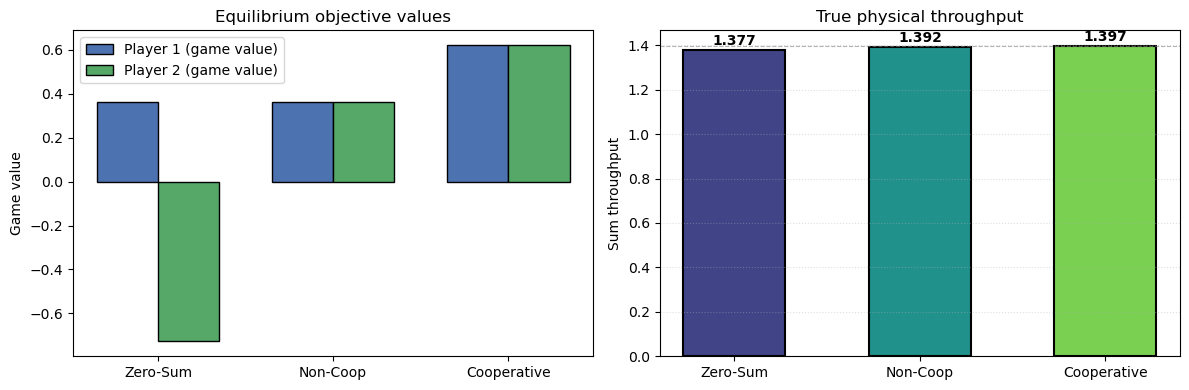

=== Numerical Summary ===
Zero-Sum       | val1=0.36053  val2=-0.72782  → true r1=0.69218, r2=0.68531, sum=1.37749
Non-Coop       | val1=0.36111  val2=0.36111  → true r1=0.69616, r2=0.69616, sum=1.39231
Cooperative    | val1=0.62134  val2=0.62134  → true r1=0.69863, r2=0.69863, sum=1.39725

Interpretation:
 • 'Game value' reflects each player's optimization objective, while 'true throughput' measures physical-layer rate expectation.
 • Cooperative mode maximizes the sum throughput, non-coop is moderate, and zero-sum limits the joint efficiency.


In [6]:
# --- Visualization of equilibrium values vs physical throughput ---
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# (a) Game objective values
x = np.arange(len(modes))
width = 0.35
ax[0].bar(x - width/2, vals1, width, label='Player 1 (game value)', color="#4C72B0", edgecolor="black")
ax[0].bar(x + width/2, vals2, width, label='Player 2 (game value)', color="#55A868", edgecolor="black")
ax[0].set_xticks(x)
ax[0].set_xticklabels(modes)
ax[0].set_ylabel("Game value")
ax[0].set_title("Equilibrium objective values")
ax[0].legend()

# (b) True physical throughput — add gradients + labels + outline
throughputs = [sum_z, sum_n, sum_c]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(modes)))
bars = ax[1].bar(x, throughputs, color=colors, edgecolor="black", linewidth=1.5, width=0.55)

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.3f}",
               ha='center', va='bottom', fontsize=10, fontweight='bold')

# Optional reference line at the max throughput for visual contrast
ax[1].axhline(max(throughputs), color="gray", linestyle="--", linewidth=0.8, alpha=0.6)

ax[1].set_xticks(x)
ax[1].set_xticklabels(modes)
ax[1].set_ylabel("Sum throughput")
ax[1].set_title("True physical throughput")
ax[1].grid(axis="y", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()


# --- Numerical summary ---
print("=== Numerical Summary ===")
for name, v1, v2, ssum, r1, r2 in zip(
    modes, vals1, vals2,
    [sum_z, sum_n, sum_c],
    [r1_z, r1_n, r1_c],
    [r2_z, r2_n, r2_c]
):
    print(f"{name:14s} | val1={v1:7.5f}  val2={v2:7.5f}  "
          f"→ true r1={r1:7.5f}, r2={r2:7.5f}, sum={ssum:7.5f}")

print("\nInterpretation:")
print(" • 'Game value' reflects each player's optimization objective, "
      "while 'true throughput' measures physical-layer rate expectation.")
print(" • Cooperative mode maximizes the sum throughput, "
      "non-coop is moderate, and zero-sum limits the joint efficiency.")


## Parte 2
(reservado para formulação/solução via LCP-Lemke a ser adicionada depois)


In [7]:

# === Parte 2: Formulação LCP (Lemke) ===
from quantecon.optimize.lcp_lemke import lcp_lemke

def build_lcp_mq(defs, v1, v2):
    """
    Constroi as matrizes M e q do LCP não cooperativo (DECENTRNONCOOP),
    seguindo a formulação do script MATLAB (queue_lcp.m).
    Retorna M, q e NVars (dimensão por jogador).
    """
    NS, NB, NA, NB_adm = defs['NS'], defs['NB'], defs['NA'], defs['NB_adm']
    PL, Pq = defs['PL'], defs['P']
    c1, c2 = defs['c1'], defs['c2']
    queuepos1 = defs['queuepos1']

    NVars = NS * NB * NA * NB_adm  # variáveis por jogador

    # Matrizes de custo A (p1) e B (p2)
    A = np.zeros((NVars, NVars))
    B = np.zeros((NVars, NVars))

    def idx(i, j, a, b):
        return queuepos1(i, j, a, b)

    for i in range(NS):
        for j in range(NB):
            for a in range(NA):
                for b in range(NB_adm):
                    row = idx(i, j, a, b)
                    for k in range(NS):
                        for l in range(NB):
                            for d in range(NA):
                                for e in range(NB_adm):
                                    col = idx(k, l, d, e)
                                    # Regras de congelamento se fila vazia
                                    if (l > 0) and (j > 0):
                                        A[row, col] = c1[i, a, k, d]
                                        B[row, col] = c2[i, a, k, d]
                                    elif (l > 0) and (j == 0):
                                        A[row, col] = c1[i, 0, k, d]
                                        B[row, col] = c2[i, 0, k, d]
                                    elif (j > 0) and (l == 0):
                                        A[row, col] = c1[i, a, k, 0]
                                        B[row, col] = c2[i, a, k, 0]
                                    # ambos vazios -> 0

    maxe = max(np.max(A), np.max(B))
    A = A - maxe
    B = B - maxe

    # Equações de fluxo (balanceamento)
    n_states = NS * NB
    G = np.zeros((n_states, NVars))
    def sidx(ii, jj): return ii * NB + jj

    for y in range(NS):
        for z in range(NB):
            row = sidx(y, z)
            for i in range(NS):
                for j in range(NB):
                    for a in range(NA):
                        for b in range(NB_adm):
                            col = idx(i, j, a, b)
                            G[row, col] = ((i == y) and (j == z)) - PL[i, y] * Pq[j, a, b, z]

    g = np.zeros(n_states)

    # Restrições de potência + normalização
    temp1 = np.zeros((1, NVars))
    temp2 = np.zeros((1, NVars))
    for i in range(NS):
        for j in range(NB):
            for a in range(NA):
                for b in range(NB_adm):
                    col = idx(i, j, a, b)
                    power = a  # ação de potência em escala 0..NA-1
                    if j > 0:
                        temp1[0, col] = power
                        temp2[0, col] = power
    ones_row = np.ones((1, NVars))

    E = np.vstack([G, temp1, ones_row])
    F = np.vstack([G, temp2, ones_row])

    O = np.zeros((NVars, NVars))
    oo = np.zeros_like(E)
    o = np.zeros((E.shape[0], E.shape[0]))

    M = np.block([
        [O,   -A,  E.T, -E.T, oo.T,  oo.T],
        [-B.T, O,  oo.T, oo.T, F.T, -F.T],
        [-E,  oo,   o,    o,    o,    o],
        [E,   oo,   o,    o,    o,    o],
        [oo, -F,   o,    o,    o,    o],
        [oo,  F,   o,    o,    o,    o],
    ])

    qo = np.zeros(NVars)
    e = np.concatenate([g, [v1, 1.0]])
    f = np.concatenate([g, [v2, 1.0]])
    q = np.concatenate([qo, qo, e, -e, f, -f])

    return M, q, NVars


def solve_lcp_and_check(M, q, name=""):
    res = lcp_lemke(M, q)
    z = res.z
    w = M @ z + q
    print(f"[{name}] success={res.success}, status={res.status}, iters={res.num_iter}")
    print(f"min z={z.min():.3e}, min w={w.min():.3e}, z·w={float(z @ w):.3e}")
    return res, z, w


In [8]:

# --- Teste de fumaça (3x3 conhecido) ---
M_sm = np.array([[1, 0, 0], [2, 1, 0], [2, 2, 1]], dtype=float)
q_sm = np.array([-8, -12, -14], dtype=float)
solve_lcp_and_check(M_sm, q_sm, name="smoke")


[smoke] success=True, status=0, iters=8
min z=0.000e+00, min w=0.000e+00, z·w=0.000e+00


(LCPResult(z=array([8., 0., 0.]), success=True, status=0, num_iter=8),
 array([8., 0., 0.]),
 array([0., 4., 2.]))

In [9]:

# --- LCP no modelo reduzido (NS=2, NB=2, NA=2, NB_adm=2) ---
s_reduced = Settings(NLinkStates=2, NBufferStates=2, NPowActs=2, NAdmContrActs=2,
                     ArrProb=0.5, v1=1.0, v2=1.0, CostFunction=DECENTRNONCOOP)
defs_red = queuedefs(s_reduced)
M_red, q_red, NVars_red = build_lcp_mq(defs_red, v1=s_reduced.v1, v2=s_reduced.v2)
res_red, z_red, w_red = solve_lcp_and_check(M_red, q_red, name="reduced")

# Normaliza x1/x2 para obter medidas de ocupação
x1 = z_red[:NVars_red]
x2 = z_red[NVars_red:2*NVars_red]
if x1.sum() > 0:
    rho1_red = x1 / x1.sum()
else:
    rho1_red = x1
if x2.sum() > 0:
    rho2_red = x2 / x2.sum()
else:
    rho2_red = x2
print(f"rho1 sum={rho1_red.sum():.3f}, rho2 sum={rho2_red.sum():.3f}")


[reduced] success=False, status=2, iters=25
min z=0.000e+00, min w=-1.429e-01, z·w=-2.393e+00
rho1 sum=1.000, rho2 sum=1.000


### Checagem M/q com solução do LP (modelo reduzido)
Usamos o solver LP no modelo reduzido (NS=2, NB=2, NA=2, NB_adm=2) para gerar ρ₁/ρ₂, empilhamos em z e avaliamos w = Mz + q. Se M/q estiverem consistentes, w deve ser ≥ 0 (salvo tolerâncias) e z·w≈0.


In [10]:

# --- Checagem M/q com solução LP (modelo reduzido) ---
# Usa o solver iterativo para obter rho1/rho2 e avalia w = Mz + q
s_reduced = Settings(NLinkStates=2, NBufferStates=2, NPowActs=2, NAdmContrActs=2,
                     ArrProb=0.5, v1=1.0, v2=1.0, CostFunction=DECENTRNONCOOP)
defs_red = queuedefs(s_reduced)
val1_lp, val2_lp, rho1_lp, rho2_lp = queuesolvegame_py(s_reduced, init_policy_guess=True)
M_red, q_red, NVars_red = build_lcp_mq(defs_red, v1=s_reduced.v1, v2=s_reduced.v2)

z_lp = np.concatenate([rho1_lp.flatten(), rho2_lp.flatten(), np.zeros(len(q_red) - 2*NVars_red)])
w_lp = M_red @ z_lp + q_red
print("[LP->LCP check] min w={:.3e}, max w={:.3e}, z·w={:.3e}".format(w_lp.min(), w_lp.max(), float(z_lp @ w_lp)))
neg_idx = np.where(w_lp < -1e-8)[0]
print(f"w negative count={len(neg_idx)}")


[Init] Using policy-based equilibrium guess.
[Player 1] val=0.333333, power=0.333333 (limit=1.000000)
[Player 2] val=0.333333, power=0.333333 (limit=1.000000)
[Iter 1] val1=0.333333, val2=0.333333, Δ1=3.333e-01, Δ2=3.333e-01
[Player 1] val=0.333333, power=0.333333 (limit=1.000000)
[Player 2] val=0.333333, power=0.333333 (limit=1.000000)
[Iter 2] val1=0.333333, val2=0.333333, Δ1=0.000e+00, Δ2=0.000e+00
[LP->LCP check] min w=-6.667e-01, max w=1.000e+00, z·w=1.426e+00
w negative count=2


### Resultado da checagem e provável origem do erro
Com z vindo do solver LP (modelo reduzido), obtivemos w com componentes negativas (min w≈-0.667, z·w>0). Isso indica que a formulação de M/q não está consistente com o problema original: mesmo uma solução viável do LP viola as condições de complementaridade (w≥0). Prováveis causas:
- Algum sinal ou bloco invertido em M (E/F ou A/B) em relação ao `queue_lcp.m`.
- Possível deslocamento incorreto (shift) dos custos ao subtrair `maxe`.
- Erro na montagem de G (fluxo) ou nas linhas de potência/normalização (E/F).
Próximo passo seria inspecionar w por blocos (x1, x2, multiplicadores) para localizar exatamente onde as entradas negativas surgem e alinhar os sinais/blocos com o script Matlab.


## Helpers
Ferramentas de Análise e Automação: o motor de experimentos `run_experiment_batch` recebe um grid de parâmetros (potência, taxa de chegada, etc.), gera todas as combinações, roda o jogo até convergência e coleta métricas finais (Throughput Físico Real e Backlog Médio). `plot_policy_heatmap` mostra mapas de calor de potência/admissão; `plot_results_line` compara throughput/backlog entre Coop vs Não-Coop. Use grades menores para depuração se necessário.


In [11]:

from itertools import product


def run_experiment_batch(base_settings: Settings, param_grid: dict, init_policy_guess=True, tie_keys=None):
    """
    Run batch experiments over a cartesian product of parameters.
      - base_settings: baseline Settings object
      - param_grid: dict of {param_name: list_of_values}; supports Bmax and Mode/CostFunction
      - tie_keys: list of (a,b) pairs that must be equal (e.g., ('v1','v2'))
    Returns: list of dicts with metrics and policies.
    """
    tie_keys = tie_keys or []
    keys = list(param_grid.keys())
    grids = []
    for k in keys:
        vals = param_grid[k]
        grids.append(vals if isinstance(vals, (list, tuple)) else [vals])

    results = []
    for combo in product(*grids):
        params = dict(zip(keys, combo))

        skip = False
        for pair in tie_keys:
            if len(pair) != 2:
                continue
            a, b = pair
            if a in params and b in params and params[a] != params[b]:
                skip = True
                break
        if skip:
            continue

        Bmax_local = params.get('Bmax', None)
        mode_label = params.get('Mode', None)
        cost_value = params.get('CostFunction', None)
        mode_to_cost = {'Zero-Sum': ZEROSUM, 'Non-Coop': DECENTRNONCOOP, 'Cooperative': DECENTRCOOP}
        if mode_label is not None and cost_value is None:
            cost_value = mode_to_cost.get(mode_label, mode_label)

        s_kwargs = {k: getattr(base_settings, k) for k in base_settings.__dataclass_fields__}
        for k, v in params.items():
            if k in ('Bmax', 'Mode', 'CostFunction'):
                continue
            s_kwargs[k] = v
        if cost_value is not None:
            s_kwargs['CostFunction'] = cost_value

        s = Settings(**s_kwargs)
        val1, val2, rho1, rho2 = queuesolvegame_py(s, init_policy_guess=init_policy_guess, Bmax=Bmax_local)
        defs = queuedefs(s)
        sum_rate, r1, r2 = evaluate_physical_throughput(rho1, rho2, defs)
        backlog1 = compute_average_backlog(rho1)
        backlog2 = compute_average_backlog(rho2)

        res = dict(
            settings=s,
            params=params,
            CostFunction=s.CostFunction,
            mode_label=('Zero-Sum' if s.CostFunction == ZEROSUM else ('Non-Coop' if s.CostFunction == DECENTRNONCOOP else 'Cooperative')),
            Bmax=Bmax_local,
            val1=val1,
            val2=val2,
            sum_rate=sum_rate,
            r1=r1,
            r2=r2,
            backlog1=backlog1,
            backlog2=backlog2,
            backlog_mean=0.5 * (backlog1 + backlog2),
            policy1=extract_policy(rho1, s.NLinkStates, s.NBufferStates, s.NPowActs, s.NAdmContrActs),
            policy2=extract_policy(rho2, s.NLinkStates, s.NBufferStates, s.NPowActs, s.NAdmContrActs),
            adm1=extract_admission_policy(rho1, s.NLinkStates, s.NBufferStates, s.NPowActs, s.NAdmContrActs),
            adm2=extract_admission_policy(rho2, s.NLinkStates, s.NBufferStates, s.NPowActs, s.NAdmContrActs),
            rho1=rho1,
            rho2=rho2,
        )
        for k, v in params.items():
            res[k] = v
        results.append(res)

    return results


def plot_policy_heatmap(settings: Settings, policy1, policy2, adm1, adm2, title_prefix=""):
    fig, ax = plt.subplots(2, 2, figsize=(11, 8))
    im00 = ax[0, 0].imshow(policy1, origin='lower', cmap='viridis')
    im01 = ax[0, 1].imshow(policy2, origin='lower', cmap='viridis')
    im10 = ax[1, 0].imshow(adm1, origin='lower', cmap='coolwarm')
    im11 = ax[1, 1].imshow(adm2, origin='lower', cmap='coolwarm')

    ax[0, 0].set_title(f"{title_prefix} Power – P1")
    ax[0, 1].set_title(f"{title_prefix} Power – P2")
    ax[1, 0].set_title(f"{title_prefix} Admission – P1")
    ax[1, 1].set_title(f"{title_prefix} Admission – P2")

    for a in ax.ravel():
        a.set_xlabel("Buffer state"); a.set_ylabel("Link state")
        a.set_xticks(range(settings.NBufferStates)); a.set_yticks(range(settings.NLinkStates))

    fig.colorbar(im00, ax=ax[0, 0]); fig.colorbar(im01, ax=ax[0, 1])
    fig.colorbar(im10, ax=ax[1, 0]); fig.colorbar(im11, ax=ax[1, 1])
    plt.tight_layout(); plt.show()


def plot_results_line(results, param_name, metric_key, title="", ylabel=""):
    fig, ax = plt.subplots(figsize=(7, 4))
    mode_labels = [(DECENTRNONCOOP, "Non-Coop"), (DECENTRCOOP, "Cooperative")]
    for mode, label in mode_labels:
        subset = [r for r in results if r.get('CostFunction') == mode]
        subset.sort(key=lambda r: r.get(param_name, r['params'].get(param_name, None)))
        xs = [r.get(param_name, r['params'].get(param_name, None)) for r in subset]
        ys = [r.get(metric_key, None) for r in subset]
        ax.plot(xs, ys, marker='o', label=label)
    ax.set_title(title)
    ax.set_xlabel(param_name)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.legend()
    plt.tight_layout(); plt.show()


## Parte 3
Restrição de Backlog e Políticas de Admissão: adicionamos a restrição $\mathbb{E}[\text{Backlog}] \le B_{max}$ ao LP:
$$\sum_{s \in S} \sum_{a \in A} Q_i(s) \cdot \rho(s, a) \le B_{max}$$
com $Q_i(s)$ sendo o tamanho da fila do jogador $i$ no estado $s$. Comparamos cenários restrito ($B_{max}=1.0$) e relaxado ($B_{max}=4.0$); espera-se região de rejeição maior quando o buffer permitido é menor.


In [12]:

# === Parte 3: backlog-constrained scenarios (Bmax=1.0 and 4.0) ===
base_part3 = Settings(**common_kwargs, CostFunction=DECENTRNONCOOP)
param_grid_part3 = {
    "CostFunction": [DECENTRNONCOOP, DECENTRCOOP],
    "Bmax": [1.0, 4.0],
}
results_part3 = run_experiment_batch(base_part3, param_grid_part3, init_policy_guess=True)


[Init] Using policy-based equilibrium guess.
[Player 1] val=0.320141, power=2.000000 (limit=2.000000)
[Player 2] val=0.321451, power=2.000000 (limit=2.000000)
[Iter 1] val1=0.320141, val2=0.321451, Δ1=3.201e-01, Δ2=3.215e-01
[Player 1] val=0.321451, power=2.000000 (limit=2.000000)
[Player 2] val=0.321451, power=2.000000 (limit=2.000000)
[Iter 2] val1=0.321451, val2=0.321451, Δ1=1.310e-03, Δ2=0.000e+00
[Player 1] val=0.321451, power=2.000000 (limit=2.000000)
[Player 2] val=0.321451, power=2.000000 (limit=2.000000)
[Iter 3] val1=0.321451, val2=0.321451, Δ1=0.000e+00, Δ2=0.000e+00
[Init] Using policy-based equilibrium guess.
[Player 1] val=0.360497, power=2.000000 (limit=2.000000)
[Player 2] val=0.361107, power=2.000000 (limit=2.000000)
[Iter 1] val1=0.360497, val2=0.361107, Δ1=3.605e-01, Δ2=3.611e-01
[Player 1] val=0.361107, power=2.000000 (limit=2.000000)
[Player 2] val=0.361107, power=2.000000 (limit=2.000000)
[Iter 2] val1=0.361107, val2=0.361107, Δ1=6.105e-04, Δ2=0.000e+00
[Player 1]

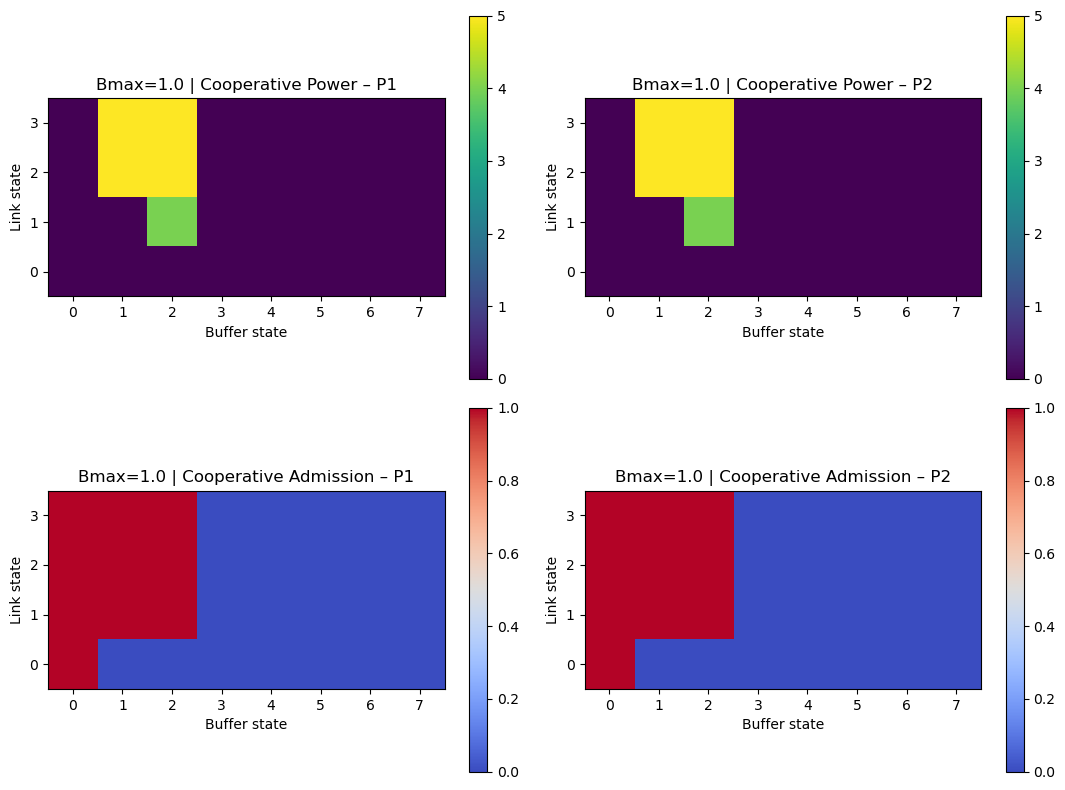

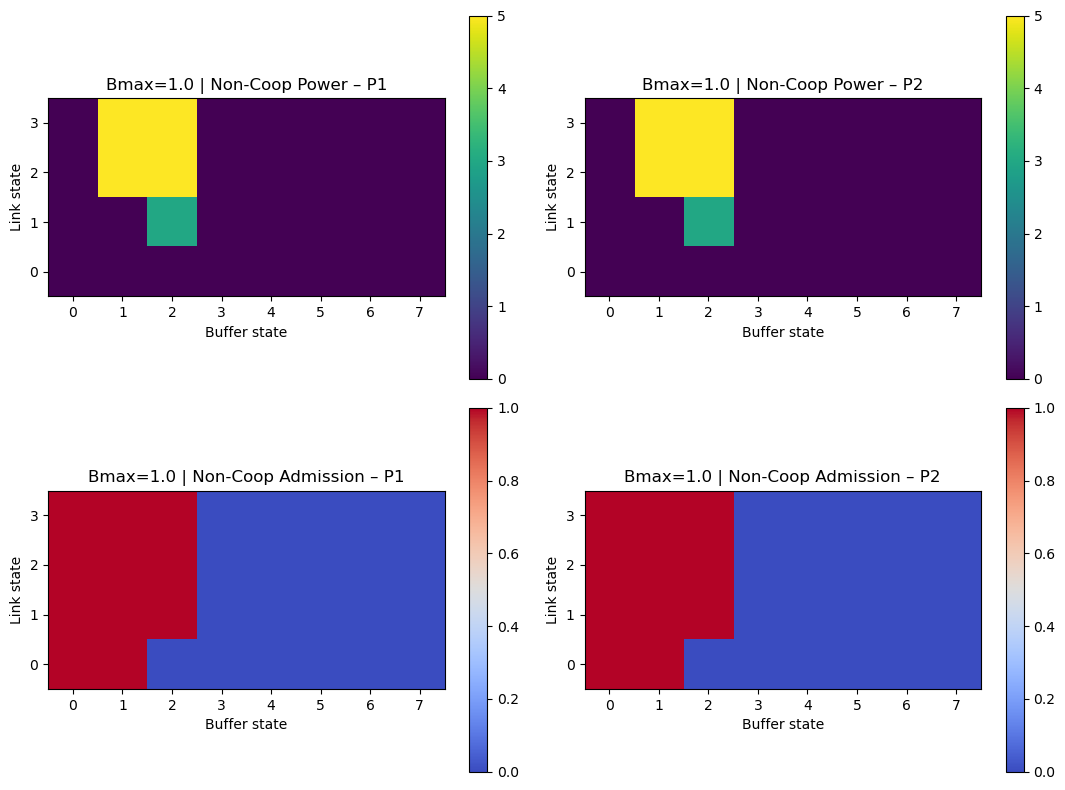

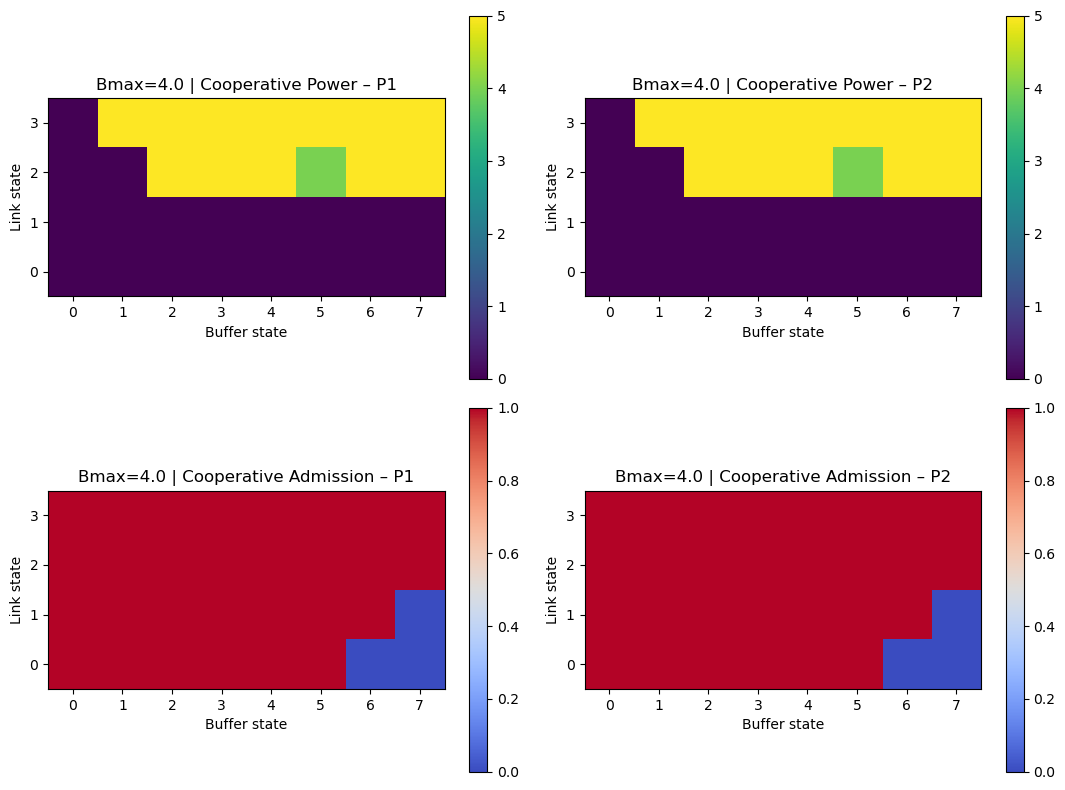

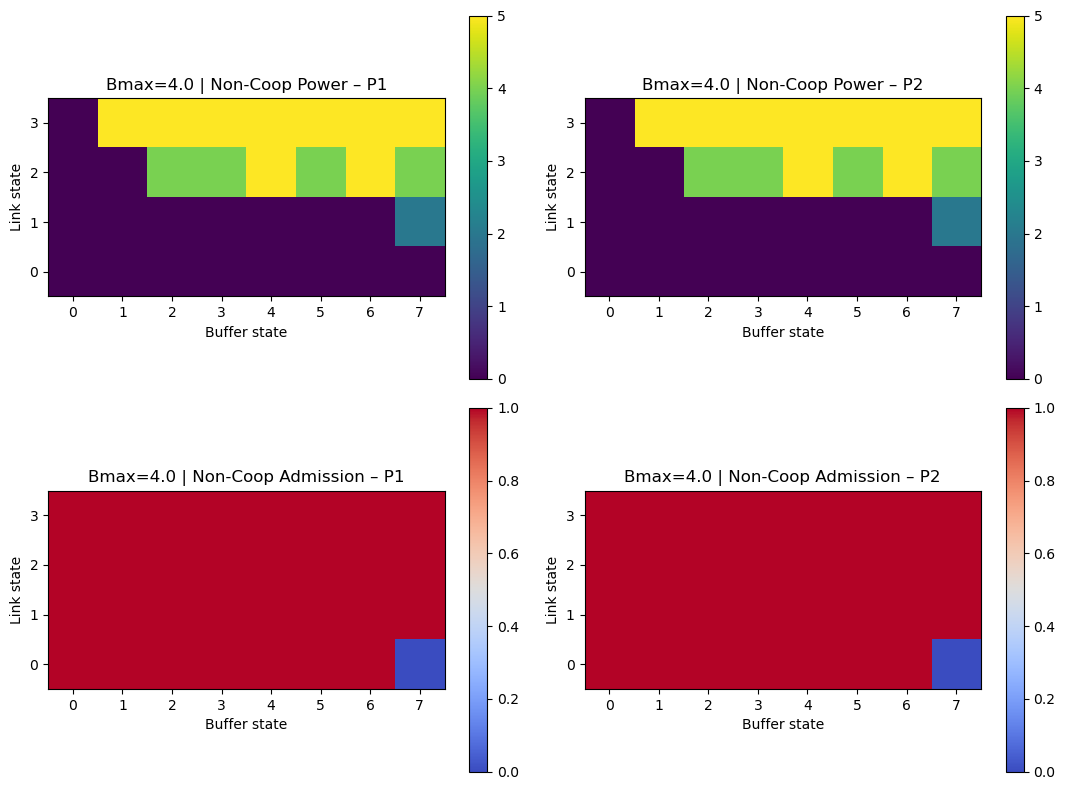

In [13]:

for r in sorted(results_part3, key=lambda x: (x["Bmax"], x["CostFunction"])):
    title = f"Bmax={r['Bmax']} | {r['mode_label']}"
    plot_policy_heatmap(r["settings"], r["policy1"], r["policy2"], r["adm1"], r["adm2"], title_prefix=title)


## Parte 4
Análise Paramétrica (Ceteris Paribus): quatro baterias variando um parâmetro de cada vez e mantendo o restante fixo.
1. **Impacto da Carga (`ArrProb`):** [0.2, 0.4, 0.6, 0.8], Bmax=3, buffer=6 — observar saturação.
2. **Potência e Interferência (`v1`= `v2`):** [1, 2, 3, 5], Bmax=3, ArrProb=0.5 — comparar eficiência Coop vs Não-Coop em alta potência.
3. **Granularidade do Canal (`NLinkStates`):** [2, 4, 6], Bmax=3 — sensibilidade à resolução do canal.
4. **Tamanho do Buffer (`NBufferStates`) sob restrição:** [4, 6, 8, 10], Bmax=3, ArrProb=0.6 — com restrição ativa, aumentar buffer físico não deve elevar backlog médio.


In [14]:

# === Parte 4A: ArrProb sweep (Bmax=3.0, buffer=6) ===
base_part4A = Settings(NLinkStates=4, NBufferStates=6, NPowActs=6, NAdmContrActs=2,
                       ArrProb=0.5, v1=v1l, v2=v1l, CostFunction=DECENTRNONCOOP)
param_grid_part4A = {
    "ArrProb": [0.2, 0.4, 0.6, 0.8],
    "CostFunction": [DECENTRNONCOOP, DECENTRCOOP],
    "Bmax": [3.0],
}
results_part4A = run_experiment_batch(base_part4A, param_grid_part4A, init_policy_guess=True)


[Init] Using policy-based equilibrium guess.
[Player 1] val=0.177580, power=0.985088 (limit=2.000000)
[Player 2] val=0.178494, power=0.985088 (limit=2.000000)
[Iter 1] val1=0.177580, val2=0.178494, Δ1=1.776e-01, Δ2=1.785e-01
[Player 1] val=0.178494, power=0.985088 (limit=2.000000)
[Player 2] val=0.178494, power=0.985088 (limit=2.000000)
[Iter 2] val1=0.178494, val2=0.178494, Δ1=9.138e-04, Δ2=0.000e+00
[Player 1] val=0.178494, power=0.985088 (limit=2.000000)
[Player 2] val=0.178494, power=0.985088 (limit=2.000000)
[Iter 3] val1=0.178494, val2=0.178494, Δ1=0.000e+00, Δ2=0.000e+00
[Init] Using policy-based equilibrium guess.
[Player 1] val=0.463508, power=0.985088 (limit=2.000000)
[Player 2] val=0.334887, power=0.985088 (limit=2.000000)
[Iter 1] val1=0.463508, val2=0.334887, Δ1=4.635e-01, Δ2=3.349e-01
[Player 1] val=0.334887, power=0.985088 (limit=2.000000)
[Player 2] val=0.334887, power=0.985088 (limit=2.000000)
[Iter 2] val1=0.334887, val2=0.334887, Δ1=1.286e-01, Δ2=0.000e+00
[Player 1]

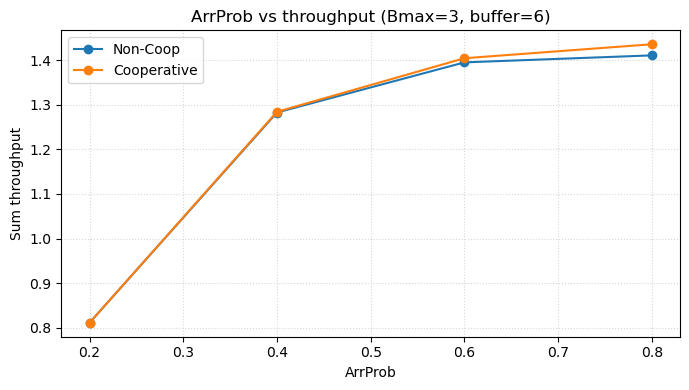

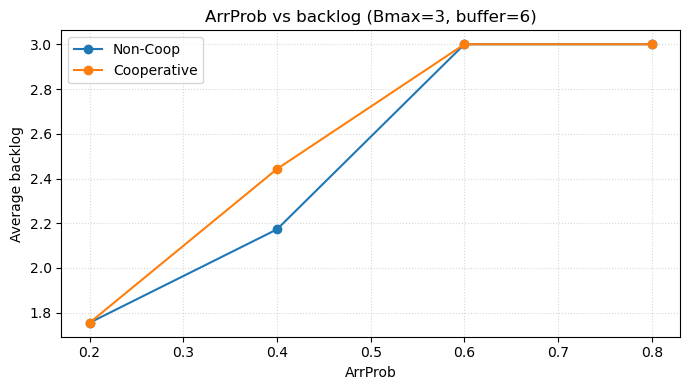

In [15]:

plot_results_line(results_part4A, "ArrProb", "sum_rate",
                  title="ArrProb vs throughput (Bmax=3, buffer=6)",
                  ylabel="Sum throughput")
plot_results_line(results_part4A, "ArrProb", "backlog_mean",
                  title="ArrProb vs backlog (Bmax=3, buffer=6)",
                  ylabel="Average backlog")


In [16]:

# === Parte 4B: Power sweep (v1=v2, Bmax=3.0, ArrProb=0.5) ===
base_part4B = Settings(**common_kwargs, CostFunction=DECENTRNONCOOP)
param_grid_part4B = {
    "v1": [1.0, 2.0, 3.0, 5.0],
    "v2": [1.0, 2.0, 3.0, 5.0],
    "CostFunction": [DECENTRNONCOOP, DECENTRCOOP],
    "Bmax": [3.0],
}
results_part4B = run_experiment_batch(base_part4B, param_grid_part4B, init_policy_guess=True, tie_keys=[("v1", "v2")])


[Init] Using policy-based equilibrium guess.
[Player 1] val=0.230747, power=1.000000 (limit=1.000000)
[Player 2] val=0.234181, power=1.000000 (limit=1.000000)
[Iter 1] val1=0.230747, val2=0.234181, Δ1=2.307e-01, Δ2=2.342e-01
[Player 1] val=0.233584, power=1.000000 (limit=1.000000)
[Player 2] val=0.233584, power=1.000000 (limit=1.000000)
[Iter 2] val1=0.233584, val2=0.233584, Δ1=2.837e-03, Δ2=5.967e-04
[Player 1] val=0.233584, power=1.000000 (limit=1.000000)
[Player 2] val=0.233584, power=1.000000 (limit=1.000000)
[Iter 3] val1=0.233584, val2=0.233584, Δ1=0.000e+00, Δ2=0.000e+00
[Init] Using policy-based equilibrium guess.
[Player 1] val=0.525520, power=1.000000 (limit=1.000000)
[Player 2] val=0.432517, power=1.000000 (limit=1.000000)
[Iter 1] val1=0.525520, val2=0.432517, Δ1=5.255e-01, Δ2=4.325e-01
[Player 1] val=0.432550, power=1.000000 (limit=1.000000)
[Player 2] val=0.432550, power=1.000000 (limit=1.000000)
[Iter 2] val1=0.432550, val2=0.432550, Δ1=9.297e-02, Δ2=3.315e-05
[Player 1]

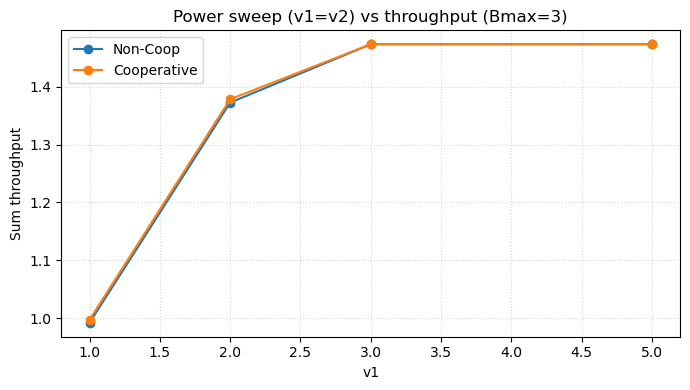

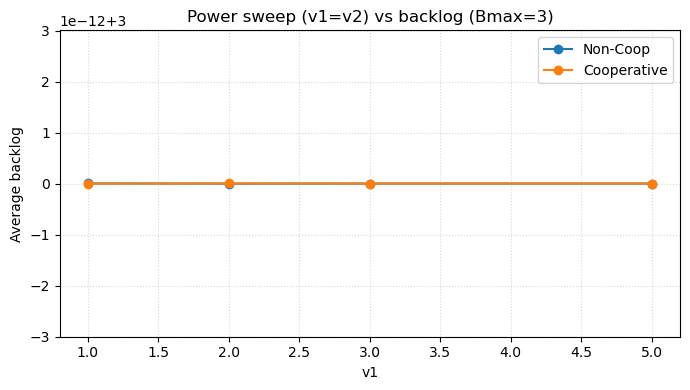

In [17]:

plot_results_line(results_part4B, "v1", "sum_rate",
                  title="Power sweep (v1=v2) vs throughput (Bmax=3)",
                  ylabel="Sum throughput")
plot_results_line(results_part4B, "v1", "backlog_mean",
                  title="Power sweep (v1=v2) vs backlog (Bmax=3)",
                  ylabel="Average backlog")


In [18]:

# === Parte 4C: Channel granularity sweep (NLinkStates) ===
base_part4C = Settings(**common_kwargs, CostFunction=DECENTRNONCOOP)
param_grid_part4C = {
    "NLinkStates": [2, 4, 6],
    "CostFunction": [DECENTRNONCOOP, DECENTRCOOP],
    "Bmax": [3.0],
}
results_part4C = run_experiment_batch(base_part4C, param_grid_part4C, init_policy_guess=True)


[Init] Using policy-based equilibrium guess.
[Player 1] val=0.427697, power=2.000000 (limit=2.000000)
[Player 2] val=0.425045, power=2.000000 (limit=2.000000)
[Iter 1] val1=0.427697, val2=0.425045, Δ1=4.277e-01, Δ2=4.250e-01
[Player 1] val=0.425045, power=2.000000 (limit=2.000000)
[Player 2] val=0.425045, power=2.000000 (limit=2.000000)
[Iter 2] val1=0.425045, val2=0.425045, Δ1=2.652e-03, Δ2=5.551e-17
[Player 1] val=0.425045, power=2.000000 (limit=2.000000)
[Player 2] val=0.425045, power=2.000000 (limit=2.000000)
[Iter 3] val1=0.425045, val2=0.425045, Δ1=0.000e+00, Δ2=0.000e+00
[Init] Using policy-based equilibrium guess.
[Player 1] val=0.499199, power=2.000000 (limit=2.000000)
[Player 2] val=0.710608, power=2.000000 (limit=2.000000)
[Iter 1] val1=0.499199, val2=0.710608, Δ1=4.992e-01, Δ2=7.106e-01
[Player 1] val=0.710608, power=2.000000 (limit=2.000000)
[Player 2] val=0.710608, power=2.000000 (limit=2.000000)
[Iter 2] val1=0.710608, val2=0.710608, Δ1=2.114e-01, Δ2=1.110e-16
[Player 1]

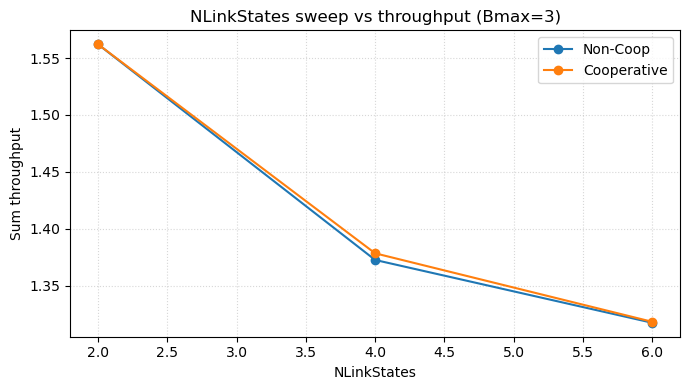

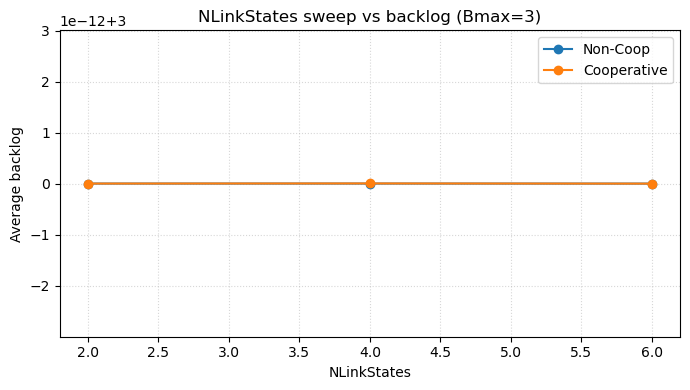

In [19]:

plot_results_line(results_part4C, "NLinkStates", "sum_rate",
                  title="NLinkStates sweep vs throughput (Bmax=3)",
                  ylabel="Sum throughput")
plot_results_line(results_part4C, "NLinkStates", "backlog_mean",
                  title="NLinkStates sweep vs backlog (Bmax=3)",
                  ylabel="Average backlog")


In [20]:
# === Parte 4D: Buffer size sweep (Bmax=3.0, ArrProb=0.6) ===
base_part4D_kwargs = dict(common_kwargs)
base_part4D_kwargs["ArrProb"] = 0.6
base_part4D = Settings(**base_part4D_kwargs, CostFunction=DECENTRNONCOOP)
param_grid_part4D = {
    "NBufferStates": [4, 6, 8, 10],
    "CostFunction": [DECENTRNONCOOP, DECENTRCOOP],
    "Bmax": [3.0],
}
results_part4D = run_experiment_batch(base_part4D, param_grid_part4D, init_policy_guess=True)


[Init] Using policy-based equilibrium guess.
[Player 1] val=0.360305, power=2.000000 (limit=2.000000)
[Player 2] val=0.355821, power=2.000000 (limit=2.000000)
[Iter 1] val1=0.360305, val2=0.355821, Δ1=3.603e-01, Δ2=3.558e-01
[Player 1] val=0.355827, power=2.000000 (limit=2.000000)
[Player 2] val=0.355827, power=2.000000 (limit=2.000000)
[Iter 2] val1=0.355827, val2=0.355827, Δ1=4.478e-03, Δ2=6.637e-06
[Player 1] val=0.355827, power=2.000000 (limit=2.000000)
[Player 2] val=0.355827, power=2.000000 (limit=2.000000)
[Iter 3] val1=0.355827, val2=0.355827, Δ1=0.000e+00, Δ2=0.000e+00
[Init] Using policy-based equilibrium guess.
[Player 1] val=0.508240, power=2.000000 (limit=2.000000)
[Player 2] val=0.624767, power=2.000000 (limit=2.000000)
[Iter 1] val1=0.508240, val2=0.624767, Δ1=5.082e-01, Δ2=6.248e-01
[Player 1] val=0.613443, power=2.000000 (limit=2.000000)
[Player 2] val=0.613443, power=2.000000 (limit=2.000000)
[Iter 2] val1=0.613443, val2=0.613443, Δ1=1.052e-01, Δ2=1.132e-02
[Player 1]

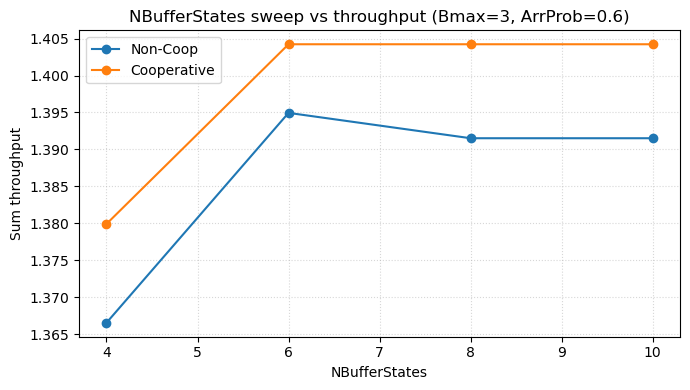

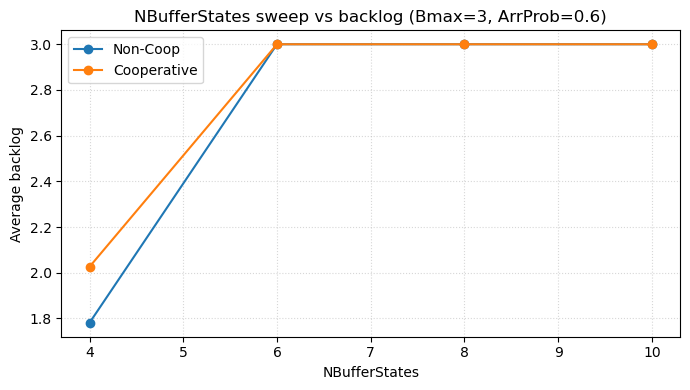

In [21]:

plot_results_line(results_part4D, "NBufferStates", "sum_rate",
                  title="NBufferStates sweep vs throughput (Bmax=3, ArrProb=0.6)",
                  ylabel="Sum throughput")
plot_results_line(results_part4D, "NBufferStates", "backlog_mean",
                  title="NBufferStates sweep vs backlog (Bmax=3, ArrProb=0.6)",
                  ylabel="Average backlog")
